In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
%matplotlib inline

## connect to database

In [2]:
#In Python: Define a database name (we're using a dataset on births, so I call it 
# birth_db), and your username for your computer (CHANGE IT BELOW). 
dbname = 'music_db'
username = 'shayneufeld'

# connect:
con = None
con = psycopg2.connect(database = dbname, user = username)

sql_query = """
SELECT * FROM bandcamp_table;
"""
bandcamp_table = pd.read_sql_query(sql_query,con)
print('bandcamp_table has %.0f rows' % bandcamp_table.shape[0])

bandcamp_table has 1520438 rows


## look for albums with the most shared followers

In [103]:
a = bandcamp_table[bandcamp_table.contrib_url == 'https://bandcamp.com/FrealFan2?from=fanthanks']
a.album_url.unique()

array(['https://dreamcatalogue.bandcamp.com/album/--18'], dtype=object)

In [100]:
bandcamp_table.iloc[4000,:]

index                                                     1111
artist_name                                             [2814]
contrib_name                                     ['Carlos L.']
contrib_url      https://bandcamp.com/FrealFan2?from=fanthanks
album_name                                                --18
album_url       https://dreamcatalogue.bandcamp.com/album/--18
Name: 4000, dtype: object

Note! It's saying about that there are ~170,000 duplicates in the database. how could that be. if every item is different. but still. I checked with an example two cells up. it seems to be true. 

so i'm going to drop those for now:

In [5]:
bandcamp_table = bandcamp_table.drop_duplicates()
bandcamp_table.shape[0]

476180

In [6]:
artists = bandcamp_table.artist_name.unique()
supporters = bandcamp_table.contrib_url.unique()
items = bandcamp_table.album_url.unique()
num_artists = artists.shape[0]
num_supporters = supporters.shape[0]
num_items = items.shape[0]

print('BANDCAMP ALBUM SCRAPING')
print('There are %.0f different artists and %.0f supporters that supported %.0f different products' % 
      (num_artists,num_supporters,num_items))


BANDCAMP ALBUM SCRAPING
There are 2464 different artists and 243019 supporters that supported 2986 different products


In [9]:
bandcamp_table.head(5)

,index,artist_name,contrib_name,contrib_url,album_name,album_url
0,0,[2814],['geniodelic515'],https://bandcamp.com/geniodelic515?from=fanthanks,--18,https://dreamcatalogue.bandcamp.com/album/--18
1,1,[2814],['vaporwavedepression'],https://bandcamp.com/vaporwavedepression?from=...,--18,https://dreamcatalogue.bandcamp.com/album/--18
2,2,[2814],['DJW'],https://bandcamp.com/danisthefan?from=fanthanks,--18,https://dreamcatalogue.bandcamp.com/album/--18
3,3,[2814],['jsr123'],https://bandcamp.com/jsr123?from=fanthanks,--18,https://dreamcatalogue.bandcamp.com/album/--18
4,4,[2814],['KingBo0?'],https://bandcamp.com/kingbo0?from=fanthanks,--18,https://dreamcatalogue.bandcamp.com/album/--18


## top 10 supporters

In [7]:
bandcamp_table.contrib_url.value_counts()[0:10]

https://bandcamp.com/cguts?from=fanthanks              93
https://bandcamp.com/camryn?from=fanthanks             62
https://bandcamp.com/chip11under?from=fanthanks        59
https://bandcamp.com/kaz?from=fanthanks                57
https://bandcamp.com/johnmay?from=fanthanks            56
https://bandcamp.com/mikeallin?from=fanthanks          51
https://bandcamp.com/mbarry?from=fanthanks             51
https://bandcamp.com/jonathansprague?from=fanthanks    50
https://bandcamp.com/sebsokk?from=fanthanks            50
https://bandcamp.com/_ohm?from=fanthanks               50
Name: contrib_url, dtype: int64

(0, 20)

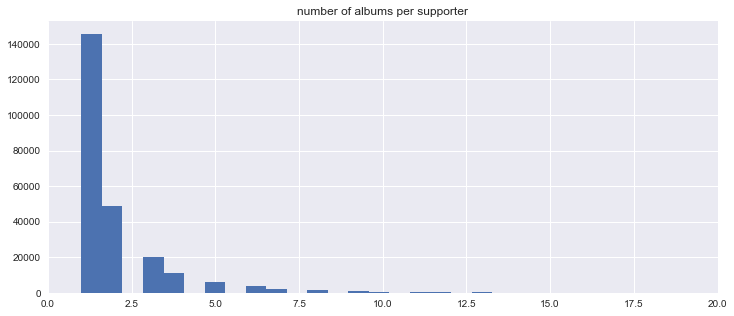

In [8]:
supporter_counts = bandcamp_table.contrib_url.value_counts()
plt.figure(figsize=(12,5))
plt.hist(supporter_counts,bins=150)
plt.title('number of albums per supporter')
plt.xlim(0,20)

# Construct adjaceny matrix of bands x users

In [18]:
adj_matrix = np.zeros((num_artists,num_supporters))

for i,artist in tqdm(enumerate(artists)):
    
    artist_df = bandcamp_table[bandcamp_table.artist_name == artist]
    supporter_ids = []
    if artist_df.shape[0] > 50:
        for supporter in artist_df.contrib_url.values:
            supporter_ids.append(np.where(supporters == supporter)[0][0])

        adj_matrix[i,supporter_ids] = 1


0it [00:00, ?it/s]
4it [00:22, 11.72s/it]

KeyboardInterrupt: 

In [109]:
np.savetxt('/Users/shayneufeld/Dropbox/insight/pricecamp/adj_matrix.csv',adj_matrix)

2141it [1:20:05,  1.41it/s]


In [32]:
artists.shape

(2464,)

In [28]:
bandcamp_table.head(2)

,index,artist_name,contrib_name,contrib_url,album_name,album_url
0,0,[2814],['geniodelic515'],https://bandcamp.com/geniodelic515?from=fanthanks,--18,https://dreamcatalogue.bandcamp.com/album/--18
1,1,[2814],['vaporwavedepression'],https://bandcamp.com/vaporwavedepression?from=...,--18,https://dreamcatalogue.bandcamp.com/album/--18


In [30]:
for supporter in tqdm(supporters):
    i = bandcamp_table.loc[bandcamp_table.contrib_url==supporter]


  0%|          | 867/243019 [00:51<4:08:14, 16.26it/s]

KeyboardInterrupt: 

  0%|          | 867/243019 [01:06<5:08:10, 13.10it/s]

In [121]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage

import scipy.sparse as sparse
import sklearn.cluster as cluster

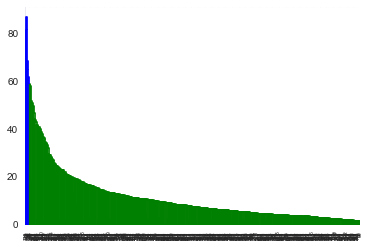

In [85]:
# try using scipy hierarchical clustering
z = linkage(adj_matrix)

dendro = dendrogram(z)

In [141]:
adj_matrix.shape

(2141, 221690)

In [114]:
#the file is really big. try using a scipy sparse matrix and do k-means clustering on that
adj_sparse = sparse.csc_matrix(adj_matrix)

In [116]:
#number of non-zero elements in the sparse matrix
adj_sparse.nnz

373348

In [119]:
#save sparse matrix
sparse.save_npz('/Users/shayneufeld/Dropbox/insight/pricecamp/adj_sparse',adj_sparse,compressed=True)

In [124]:
#k-means clustering

kmeans = cluster.KMeans(n_clusters=10)
cluster_ids = kmeans.fit_predict(adj_sparse)

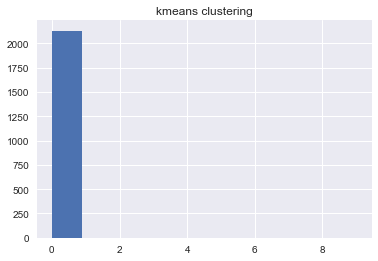

In [161]:
plt.hist(cluster_ids)
plt.title('kmeans clustering')

that doesn't look good. everything was clustered into cluster 0

In [144]:
# how many columns have only 1?

num_supports = adj_matrix.sum(axis=0)
num_supports.shape

(221690,)

In [153]:
solo_supporters = np.where(num_supports == 1)
multi_supporters = np.where(num_supports > 2)

In [158]:
multi_supporters[0]

array([     1,      3,      4, ..., 208362, 211554, 212034])

In [155]:
solo_supporters[:5]

(array([     0,      2,      8, ..., 221687, 221688, 221689]),)

In [159]:
adj_matrix_multi = adj_matrix[:,multi_supporters[0]]
adj_matrix_multi.shape

(2141, 32252)